In [1]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import os

from tools import PatchForager

In [2]:
# Example usage
type_patches = 2
num_patches = 400

#Three alternative ways to generate a list of patches
patch_list = list(range(type_patches)) #equal distribution of patches
# patch_list = [random.randint(0, type_patches-1) for _ in range(num_patches)] #randomly generated list of patched
# patch_list = data # import data from session {To Be Implemented..}

# Initial probabilities of reward in each patch
travel_time = 3
reward_value = [5, 5]
a = [0.9, 0.4]
b = [2.76, 2.76]
c = [0.1278, 0.1278]
d = [0, 0]

forager = PatchForager(travel_time, reward_value, a, b, c, d, prob=False)
mvt_optimal = forager.calculate_optimal_stops(patch_list)

print(f"Optimal stops: {mvt_optimal['optimal_stops'][0]}, {mvt_optimal['optimal_stops'][1]}")
print(f"Max reward rate: {mvt_optimal['max_reward_rate']}")

Optimal stops: 8, 2
Max reward rate: 1.7275262225772854


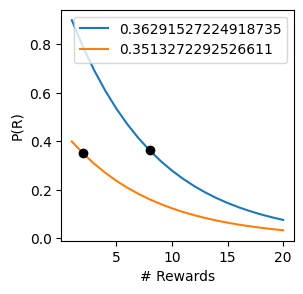

<Figure size 640x480 with 0 Axes>

In [3]:
forager.make_pr_plot(patch_list, mvt_optimal['optimal_stops'])

plt.savefig(f'figs/mvt_curves.png')

In [11]:
# Create a directory for the simulation results
import h5py
os.makedirs('data', exist_ok=True)

type_patches = 2
num_patches = 200
patch_list = [random.randint(0, type_patches-1) for _ in range(num_patches)] #randomly generated list of patched

forager = PatchForager(travel_time, reward_value, a, b, c, d, prob=True)

# Create an HDF5 file
with h5py.File('data/data.h5', 'w') as hf:
    for i in range(20):

        # Run the simulation
        mvt_stops_data,_ = forager.run_simulation('target_stops', patch_list, target_stops=mvt_optimal['optimal_stops'])#[8,6])#
        mvt_rate_data,_ = forager.run_simulation('mvt_rate', patch_list, target_reward_rate=2.45)#mvt_optimal['max_reward_rate'])#2.4)#)
        fixed_failures_data,_ = forager.run_simulation('fixed_failures', patch_list, max_failures=2)
        fixed_consec_failures_data,_ = forager.run_simulation('fixed_consec_failures', patch_list, consec_failures=2)

        # Create a group for this simulation
        sim_group = hf.create_group(f'simulation_{i}')

        # Save results
        for name, data in [('mvt_stops', mvt_stops_data),
                           ('mvt_rate', mvt_rate_data),
                           # ('fixed_rewards', fixed_rewards_data),
                           ('fixed_failures', fixed_failures_data),
                           ('fixed_consec_failures', fixed_consec_failures_data)]:
            dataset = sim_group.create_dataset(name, data=data.to_numpy())
            # Save column names as attributes
            dataset.attrs['columns'] = data.columns.tolist()

In [5]:
print(mvt_optimal['max_reward_rate'],mvt_optimal['optimal_stops'])

1.7275262225772854 (8, 2)


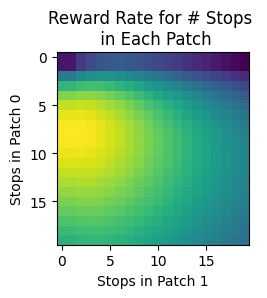

In [6]:
plt.figure(figsize=(2.5, 2.5))
plt.imshow(mvt_optimal['reward_rate_grid'])
plt.xlabel('Stops in Patch 1')
plt.ylabel('Stops in Patch 0')
plt.title('Reward Rate for # Stops \n in Each Patch')


plt.savefig(f'figs/reward_rate_grid.png')

In [12]:
# Function to read data from HDF5 file
def read_h5_data(file_path, simulation_number, strategy):
    with h5py.File(file_path, 'r') as hf:
        dataset = hf[f'simulation_{simulation_number}/{strategy}']
        return pd.DataFrame(dataset[:], columns=dataset.attrs['columns'])

# Set up the plotting style
plt.style.use('ggplot')

# File path
h5_file_path = 'data/data.h5'

# List of strategies to plot
strategies = ['mvt_rate', 'mvt_stops', 'fixed_failures', 'fixed_consec_failures']

# List of strategies to plot with their assigned colors
color_set = {
    'mvt_rate': '#1f77b4',  # blue
    'mvt_stops': '#ff7f0e',  # orange
    'fixed_failures': '#d62728',  # red
    'fixed_consec_failures': '#9467bd'  # purple
}

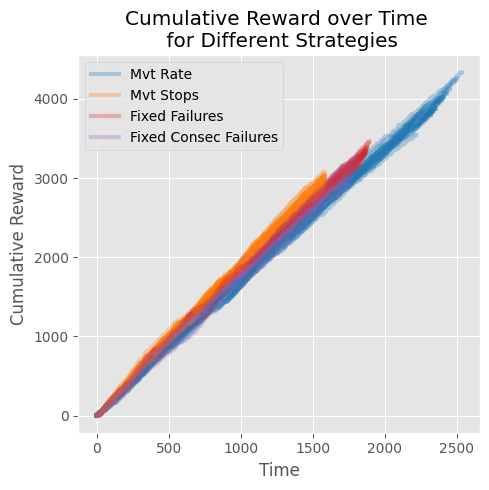

In [13]:
plt.figure(figsize=(5, 5))
for sim_num in range(20):  # Assuming 20 simulations

    for strategy in strategies:
        # Read data for this simulation and strategy
        data = read_h5_data(h5_file_path, sim_num, strategy)
        
        # Plot cumulative reward over time
        plt.plot(data['time'], data['reward'].cumsum(), label=strategy.replace('_', ' ').title(),alpha = .3,
                 lw = 3,color = color_set[strategy])

    plt.xlabel('Time')
    plt.ylabel('Cumulative Reward')
    plt.title(f'Cumulative Reward over Time \n for Different Strategies')
    
    if sim_num==0:
        plt.legend()
        
    plt.grid(True)
    plt.tight_layout()
    
    # Save the plot
plt.savefig(f'figs/cumulative_reward_all.png')
# plt.close()  # Close the figure to free up memory

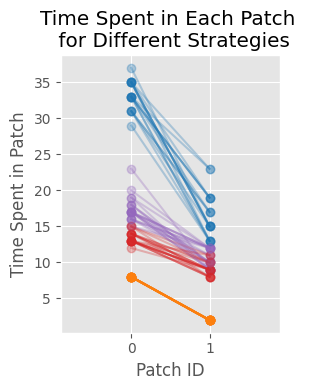

In [14]:
# Number of simulations
num_simulations = 20

# Plot: Time Spent in Each Patch
plt.figure(figsize=(3, 4))

for sim_num in range(num_simulations):
    for strategy in strategies:
        # Read data for this simulation and strategy
        data = read_h5_data(h5_file_path, sim_num, strategy)
        
        # Calculate time spent in each patch
        patch_times = data[data['patch_id'] != -1].groupby('patch_id')['time_in_patch'].max()
        
        # Plot time spent in each patch
        plt.plot(patch_times.index, patch_times.values, label=strategy if sim_num == 0 else "", 
                 marker='o', alpha=0.3, color=color_set[strategy])

plt.xlabel('Patch ID')
plt.xlim([-.9,1.9])
plt.ylabel('Time Spent in Patch')
plt.title('Time Spent in Each Patch \n for Different Strategies')
if sim_num == 0:
    plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(f'figs/patch_stops.png')


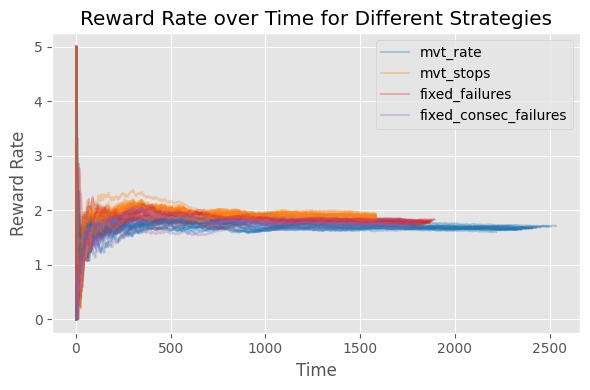

In [15]:
# Plot: Reward Rate over Time
plt.figure(figsize=(6, 4))
for sim_num in range(num_simulations):
    for strategy in strategies:
        # Read data for this simulation and strategy
        data = read_h5_data(h5_file_path, sim_num, strategy)
        
        # Calculate reward rate
        cumulative_reward = data['reward'].cumsum()
        reward_rate = cumulative_reward / data['time']
        
        # Plot reward rate over time
        plt.plot(data['time'], reward_rate, label=strategy if sim_num == 0 else "", 
                 alpha=0.3, color=color_set[strategy])
    if sim_num == 0:
        plt.legend()

plt.xlabel('Time')
plt.ylabel('Reward Rate')
plt.title('Reward Rate over Time for Different Strategies')

plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig('figs/reward_rate_all.png')